# Prediction and reconstruction for one beat

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

# This is a no-no in prod code. Use PYTHONPATH variable in shell instead

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

from reconstruct import get_exam_ids_per_file, extract_selected_tracings, reconstruct_traces

# Read file and filter

1. Read a hfd5 file; file number `file_num` from constants.py
2. The whole file may not fit in the laptop memory
3. For now, good filters are:
   * normal_ecg = True
   * abs(age - nn_predicted_age) < 1
4. df = metadata - the `exam_id` is used to read only part of the hfd5 file 
5. trace_file_path - path of the massive hfd5 file to be read. Depends upon the `file_num` variable.

In [4]:
trace_file_path, df = get_exam_ids_per_file()

2025-09-13 18:06:36 INFO     Found 10923 patients in file num 16.


In [5]:
df.head()

,exam_id,age,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,patient_id,death,timey,normal_ecg,trace_file
7057,1683849,35,False,35.244183,False,False,False,False,False,False,1397534,NaN,NaN,True,exams_part16.hdf5
7265,1754825,49,False,49.684593,False,False,False,False,False,False,959059,NaN,NaN,True,exams_part16.hdf5
7281,1689108,41,False,40.222874,False,False,False,False,False,False,1500679,False,1.101369,True,exams_part16.hdf5
7446,1715430,48,False,47.940437,False,False,False,False,False,False,1499416,NaN,NaN,True,exams_part16.hdf5
7448,1796928,41,True,41.678860,False,False,False,False,False,False,673061,False,0.915068,True,exams_part16.hdf5


In [6]:
df.shape

(772, 15)

In [7]:
trace_file_path

'../data/exams_part16.hdf5'

In [8]:
! ls ../data/exams_part16.hdf5

../data/exams_part16.hdf5


# Filter the hfd5 file

1. Read the dataframe, for the `exam_id` column
2. Take in the `trace_file_path`
3. Read that file, but only read the given `exam_id`s from the dataframe
4. If trying to read the whole hfd5 file in Jupyter Notebook - the kerner dies. RIP.

In [9]:
selected_traces = extract_selected_tracings(
    trace_file_path,
    df['exam_id'].values
)

2025-09-13 18:06:36 INFO     reading trace file: ../data/exams_part16.hdf5
2025-09-13 18:06:36 INFO     Found tracings
2025-09-13 18:06:37 INFO     Saved npy file


The np.array `selected_traces` is 3 dimentional -
* axis 0 - patients
* axis 1 - individual ECG channel - 4096 points, about 10 heartbeats data
* axis 2 - number of ECG leads

In [10]:
selected_traces.shape

(772, 4096, 12)

In [11]:
assert(len(df) == len(selected_traces)), "Number of patients should be the same."

# Picking just one patient

In [12]:
trace = selected_traces[1, :, :]
trace.shape

(4096, 12)

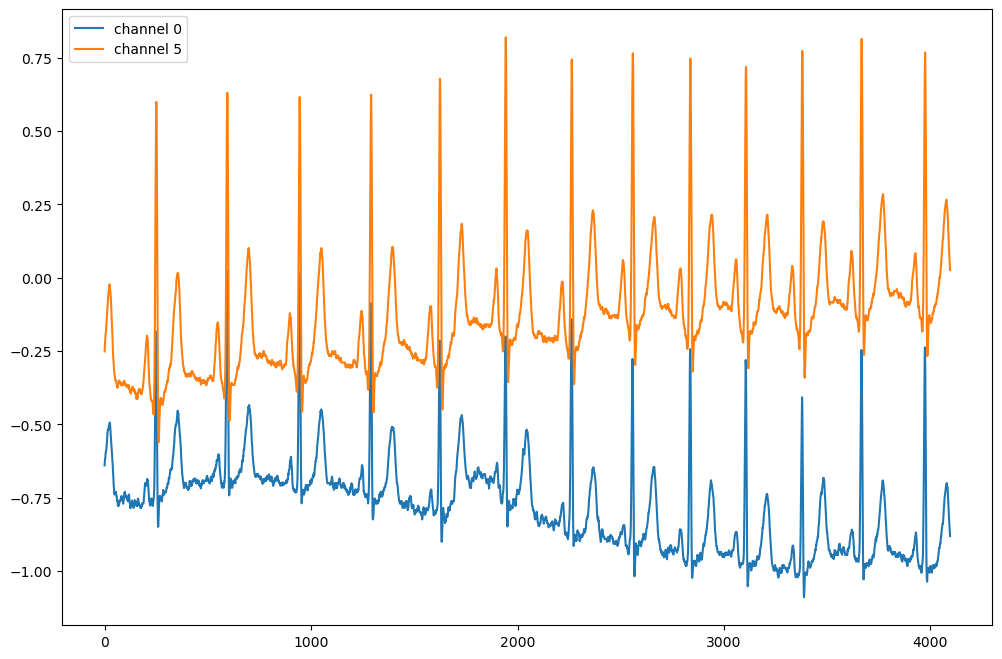

In [13]:
plt.figure(figsize=(12, 8))
i = 0
plt.plot(trace[:, i], label=f"channel {i}")  # first ECG channel
i = 5
plt.plot(trace[:, i], label=f"channel {i}")  # 8th ECG channel
plt.legend()

# ToDo
Find all the normal traces that have the following kind of abnormalities

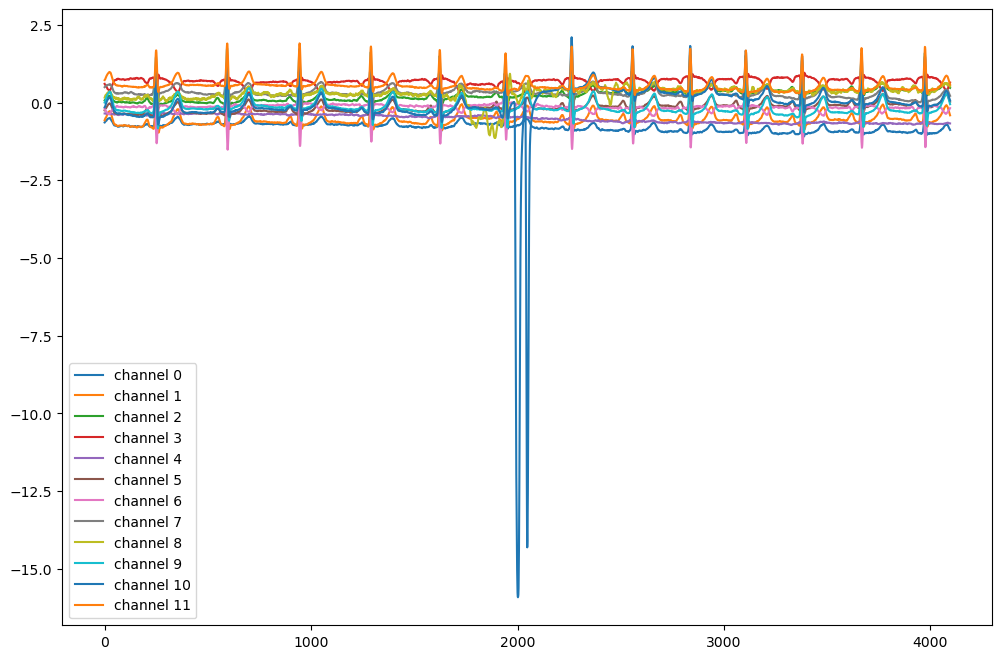

In [14]:
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.plot(trace[:, i], label=f"channel {i}")  # 8th ECG channel
plt.legend()
plt.show()

# channel 10 is odd

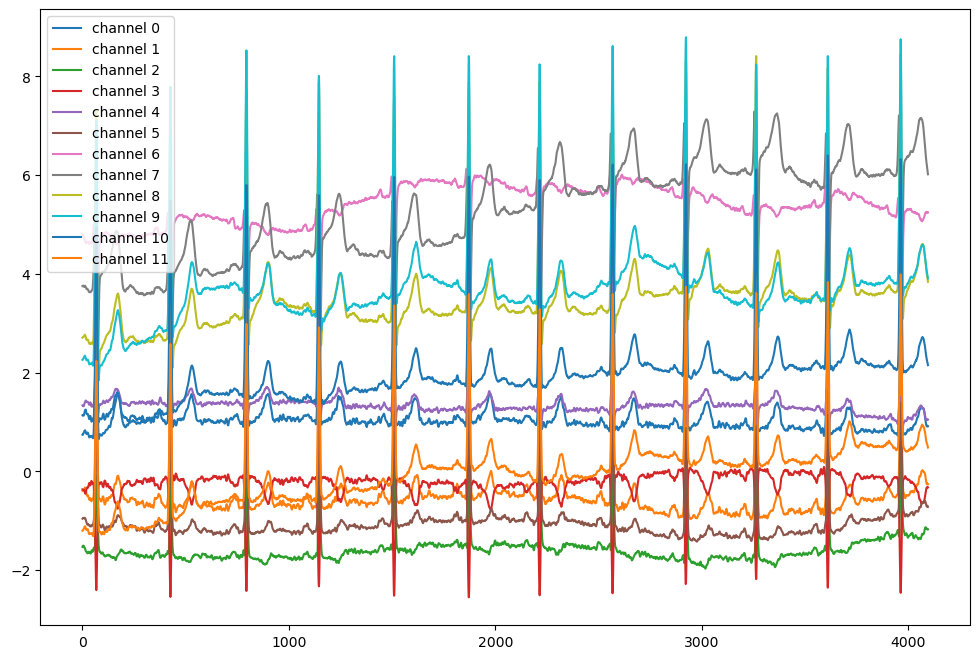

In [15]:
# Using another patient
trace = selected_traces[0, :, :]

# confirm no abnormal data
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.plot(trace[:, i], label=f"channel {i}")  # 8th ECG channel
plt.legend()
plt.show()

# chan 8 is weird

In [16]:
from reconstruct import reconstruct_traces

In [20]:
df_0 = pd.DataFrame(df.iloc[0]).T
df_0

,exam_id,age,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,patient_id,death,timey,normal_ecg,trace_file
7057,1683849,35,False,35.244183,False,False,False,False,False,False,1397534,NaN,NaN,True,exams_part16.hdf5


In [26]:
import json
import os
import torch

from constants import (
    DATA_INPUT_DIR,
    DATA_OUTPUT_DIR,
    AGE_FILTER,
    ABS_AGE_DIFF,
    EXAM_ID,
    FILE_NUM,
    N_LEADS,
    SAVE_HDF5,
)
from evaluate import predict
from resnet import ResNet1d


# setting up the model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mdl = '../model'

# Get checkpoint
ckpt = torch.load(
    os.path.join(mdl, 'model.pth'),
    weights_only=False,
    map_location=lambda storage,
    loc: storage
)

config = os.path.join(mdl, 'config.json')
with open(config, 'r') as f:
    config_dict = json.load(f)
model = ResNet1d(
    input_dim=(N_LEADS, config_dict['seq_length']),
    blocks_dim=list(zip(config_dict['net_filter_size'], config_dict['net_seq_lengh'])),
    n_classes=1,
    kernel_size=config_dict['kernel_size'],
    dropout_rate=config_dict['dropout_rate']
)

# load model checkpoint
model.load_state_dict(ckpt["model"])
model = model.to(device)


In [39]:
recon_trace_age_20 = reconstruct_traces(
    trace,
    df_0,
    model,
    recon_ages=[20]
)
recon_trace_age_35 = reconstruct_traces(
    trace,
    df_0,
    model,
    recon_ages=[35]
)   

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


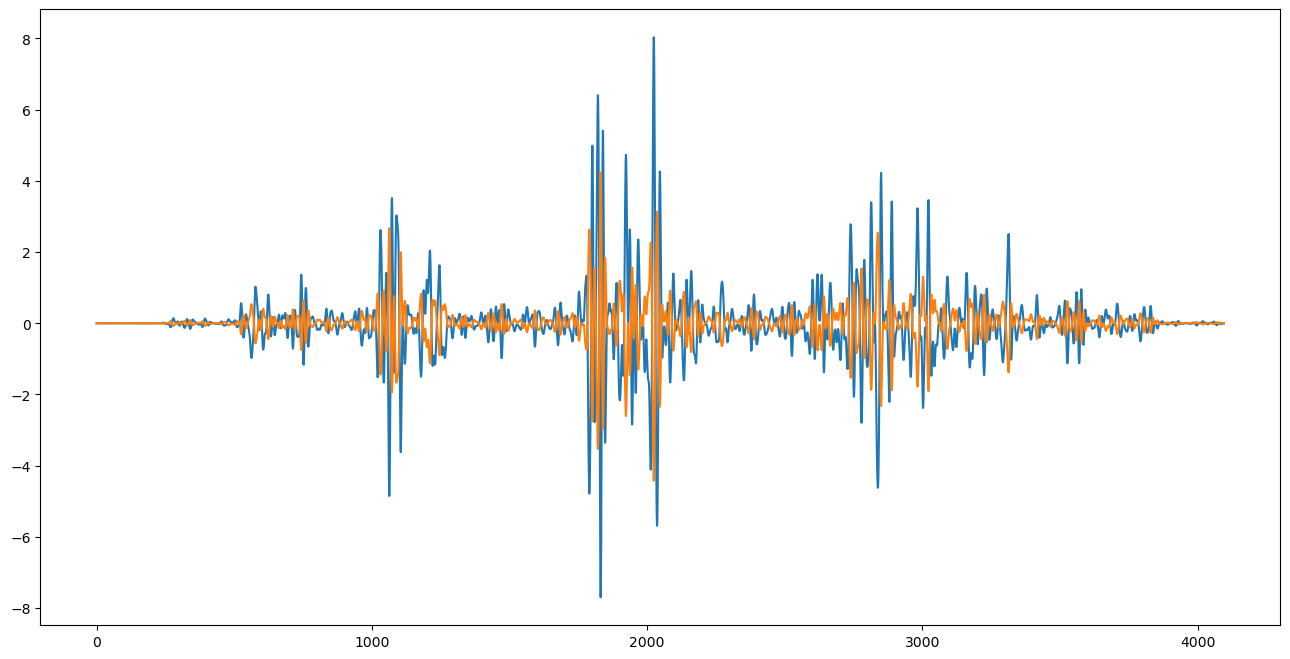

In [40]:
plt.figure(figsize=(16, 8))
chan = 3
plt.plot(recon_trace_age_20[:, chan])
plt.plot(recon_trace_age_35[:, chan])
plt.show()

# recon_trace_age_20.shape, recon_trace_age_35.shape

In [41]:
for chan in range(12):
    print(np.corrcoef(recon_trace_age_20[:, chan], recon_trace_age_35[:, chan]))

[[ 1. -1.]
 [-1.  1.]]
[[ 1. -1.]
 [-1.  1.]]
[[ 1. -1.]
 [-1.  1.]]
[[ 1. -1.]
 [-1.  1.]]
[[ 1. -1.]
 [-1.  1.]]
[[ 1. -1.]
 [-1.  1.]]
[[ 1. -1.]
 [-1.  1.]]
[[ 1. -1.]
 [-1.  1.]]
[[ 1. -1.]
 [-1.  1.]]
[[ 1. -1.]
 [-1.  1.]]
[[ 1. -1.]
 [-1.  1.]]
[[ 1. -1.]
 [-1.  1.]]


# Another patient with some abnormal data

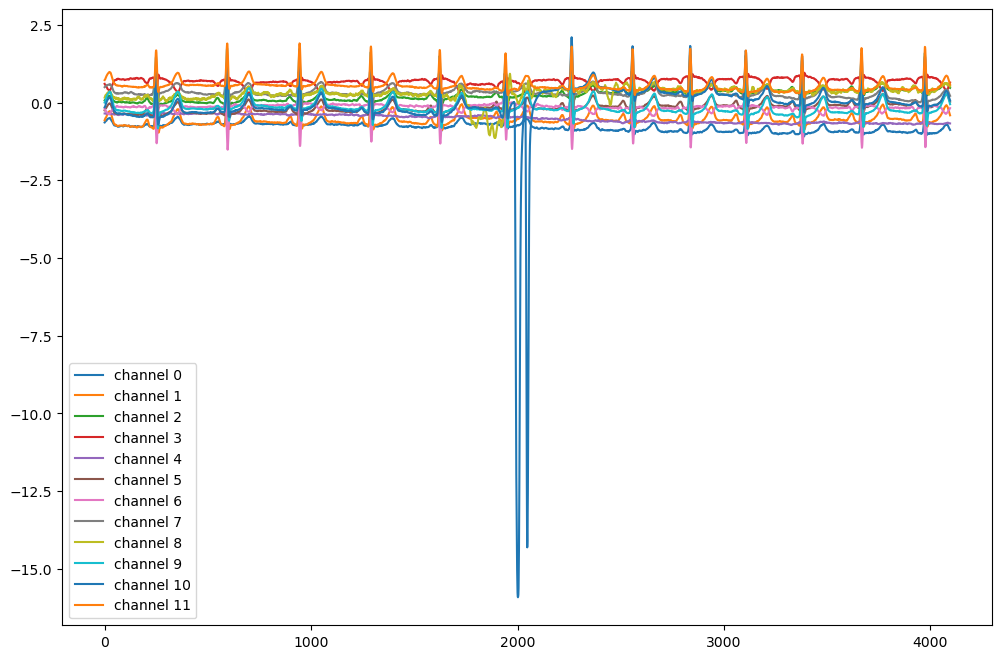

In [45]:
# Using another patient
pid = 1
trace = selected_traces[pid, :, :]

# confirm no abnormal data
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.plot(trace[:, i], label=f"channel {i}")  # 8th ECG channel
plt.legend()
plt.show()

# chan 10 is weird

In [52]:
recon_trace_age_20 = reconstruct_traces(
    trace,
    pd.DataFrame(df.iloc[pid]).T,
    model,
    recon_ages=[20]
)
recon_trace_age_49 = reconstruct_traces(
    trace,
    pd.DataFrame(df.iloc[pid]).T,
    model,
    recon_ages=[49]
)   

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.46it/s]


In [50]:
pd.DataFrame(df.iloc[pid]).T

,exam_id,age,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,patient_id,death,timey,normal_ecg,trace_file
7265,1754825,49,False,49.684593,False,False,False,False,False,False,959059,NaN,NaN,True,exams_part16.hdf5


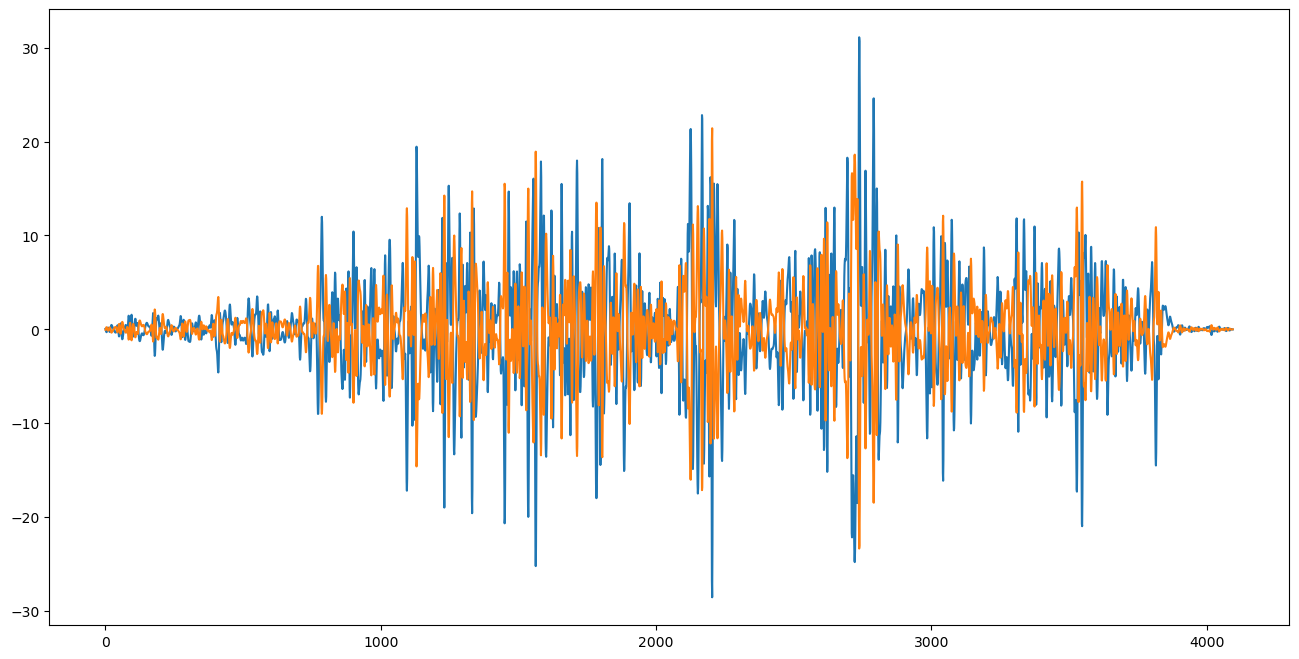

[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]
[[1. 1.]
 [1. 1.]]


In [55]:
plt.figure(figsize=(16, 8))
chan = 10
plt.plot(recon_trace_age_20[:, chan])
plt.plot(recon_trace_age_49[:, chan])
plt.show()
for chan in range(12):
    print(np.corrcoef(recon_trace_age_20[:, chan], recon_trace_age_35[:, chan]))

# Checking what does the following block of the code predict_age does:

```python
    criterion = torch.nn.MSELoss()
    loss = criterion(y_pred, y_true)
    loss.backward()
```


In [117]:
import tqdm 
from constants import batch_size


def predict_age(
    model,   # original model object
    traces,  # original traces
    ages,  # ages to reconstruct
    using_block  # checking if the part of the block does anything
):
    # If using an age range for reconstructing traces
    ids = range(len(traces))

    n_total = len(traces)

    # Get dimension
    predicted_age = np.zeros((n_total,))
    recon_trace = np.zeros(traces.shape)

    # Evaluate on test data
    model.eval()
    # n_total, n_samples, n_leads = traces.shape
    n_batches = int(np.ceil(n_total/batch_size))

    # Compute gradients
    end = 0
    for i in tqdm.tqdm(range(n_batches)):
        start = end
        end = min((i + 1) * batch_size, n_total)
        # with torch.no_grad():

        if traces.ndim == 3:
            x_leaf = torch.tensor(traces[start:end, :, :], dtype=torch.float32, requires_grad=True, device=device)
        if traces.ndim == 2:
            x_leaf = torch.tensor(np.expand_dims(trace, axis=0), dtype=torch.float32, requires_grad=True, device=device)

        # Transpose for model input (now non-leaf, so we must retain its grad)
        x = x_leaf.transpose(-1, -2)
        x.retain_grad()  # Needed to get grad for non-leaf tensor

        y_pred = model(x)

        # Example target tensor for backprop — must match your task
        y_true = torch.tensor(
            ages[start:end],
            device=device,
            dtype=torch.float32
        ).unsqueeze(1)

        # Loss and backward pass
        if using_block:
            criterion = torch.nn.MSELoss()
            loss = criterion(y_pred, y_true)
            loss.backward()

        # Store predictions
        predicted_age[start:end] = y_pred.detach().cpu().numpy().flatten()

        # Store backpropagated gradients (input reconstruction)
        recon_trace[start:end] = x.grad.detach().cpu().transpose(-1, -2).numpy().astype(np.float32)

        # Zero gradients before next batch
        model.zero_grad()

        # print(f"reconstructed_input.shape = {input_gradients}")
    # Save predictions

    df = pd.DataFrame({'ids': ids, 'predicted_age': predicted_age})
    df = df.set_index('ids')
    
    return recon_trace, df
    
def reconstruct_traces_block(
    traces,
    df_metadata,
    model,
    recon_ages,
    using_block=True
):
    ids_popln = df_metadata['exam_id'].values
    real_ages = df_metadata['age'].values
    if traces.ndim == 3:
        recon_trace = predict_age(
            model,
            traces,
            recon_ages,
            using_block,
        )
    
    if traces.ndim == 2:
        assert(len(df_metadata) == 1), \
            "Too many patients in the metadata dataframe"

    # If passing one patient, return numpy array of reconstructed traces
    if traces.ndim == 2:
        recon_trace = predict_age(
            model,
            traces,
            recon_ages,
            using_block,
        )
        # recon_trace should be only 2-dim array if only one recon_age is passed
    return recon_trace

In [118]:
traces_8 = selected_traces[:8, :, :]
df_8 = df.iloc[:8, :]
df_8

,exam_id,age,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,patient_id,death,timey,normal_ecg,trace_file
7057,1683849,35,False,35.244183,False,False,False,False,False,False,1397534,NaN,NaN,True,exams_part16.hdf5
7265,1754825,49,False,49.684593,False,False,False,False,False,False,959059,NaN,NaN,True,exams_part16.hdf5
7281,1689108,41,False,40.222874,False,False,False,False,False,False,1500679,False,1.101369,True,exams_part16.hdf5
7446,1715430,48,False,47.940437,False,False,False,False,False,False,1499416,NaN,NaN,True,exams_part16.hdf5
7448,1796928,41,True,41.678860,False,False,False,False,False,False,673061,False,0.915068,True,exams_part16.hdf5
7651,1749457,57,False,56.525887,False,False,False,False,False,False,489721,NaN,NaN,True,exams_part16.hdf5
7671,1716572,82,False,82.418434,False,False,False,False,False,False,1499842,False,1.057533,True,exams_part16.hdf5
7677,1777514,32,False,32.908820,False,False,False,False,False,False,998202,False,0.950684,True,exams_part16.hdf5


In [119]:
recon_trace_8_with_block, df_with_block = reconstruct_traces_block(
    traces_8,
    df_8,
    model,
    recon_ages=df['age'].values,
    using_block=True
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


In [120]:
recon_trace_8_with_block.shape

(8, 4096, 12)

In [121]:
df_with_block = pd.concat(
    [df_with_block.reset_index(drop=True), df_8[['exam_id', 'age', 'nn_predicted_age']].reset_index(drop=True)],
    axis=1,
    ignore_index=True,
)
df_with_block.columns = ['predicted_age', 'exam_id', 'age', 'original_pred']
df_with_block

,predicted_age,exam_id,age,original_pred
0,29.674107,1683849,35,35.244183
1,36.566284,1754825,49,49.684593
2,32.588650,1689108,41,40.222874
3,51.519508,1715430,48,47.940437
4,83.380867,1796928,41,41.678860
5,32.598839,1749457,57,56.525887
6,59.264481,1716572,82,82.418434
7,76.150490,1777514,32,32.908820


In [122]:
recon_trace_8_wo_block, df_wo_block = reconstruct_traces_block(
    traces_8,
    df_8,
    model,
    recon_ages=df['age'].values,
    using_block=False
)

df_wo_block = pd.concat(
    [df_wo_block.reset_index(drop=True), df_8[['exam_id', 'age', 'nn_predicted_age']].reset_index(drop=True)],
    axis=1,
    ignore_index=True,
)
df_wo_block.columns = ['predicted_age', 'exam_id', 'age', 'original_pred']
df_wo_block

  0%|                                                                                                                                                   | 0/1 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'detach'